Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
!pip install Augmentor

In [2]:
!pip install tensorflow

In [3]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from tensorflow.python.keras.layers import  Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical, plot_model

import Augmentor
import seaborn as sns
from glob import glob

In [ ]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [4]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin_cancer/Train/")
data_dir_test = pathlib.Path('Skin_cancer/Test/')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

                        Class  No. of Images (count)
0           actinic keratosis                    114
1        basal cell carcinoma                    376
2              dermatofibroma                     95
3                    melanoma                    438
4                       nevus                    357
5  pigmented benign keratosis                    462
6        seborrheic keratosis                     77
7     squamous cell carcinoma                    181
8             vascular lesion                    139


(array([  0., 100., 200., 300., 400., 500.]),
 [Text(0.0, 0, '0'),
  Text(100.0, 0, '100'),
  Text(200.0, 0, '200'),
  Text(300.0, 0, '300'),
  Text(400.0, 0, '400'),
  Text(500.0, 0, '500')])

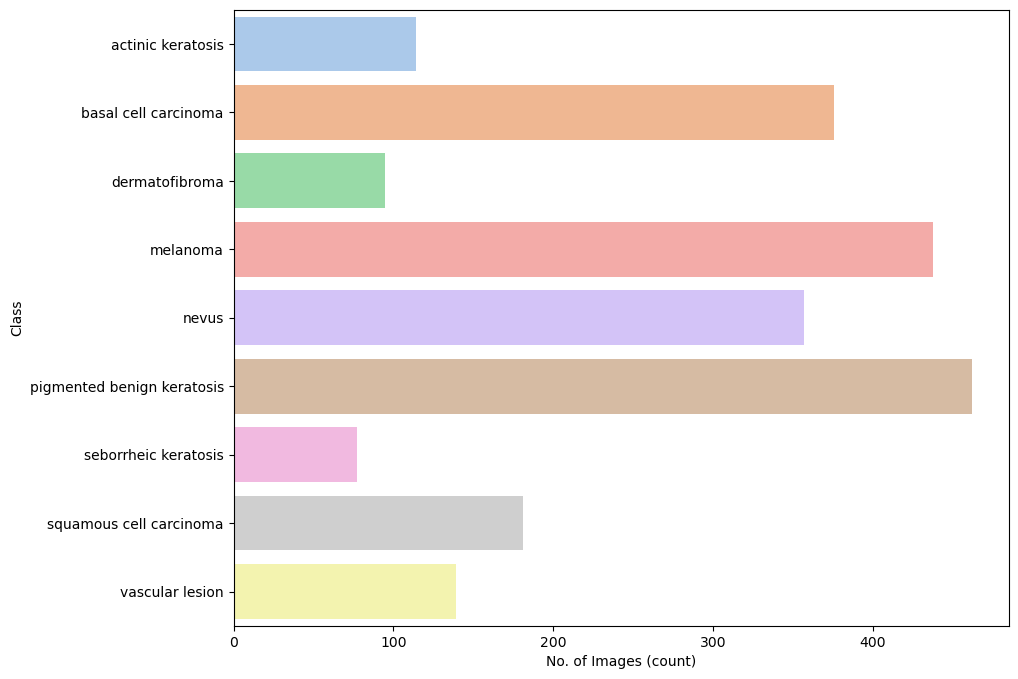

In [49]:
## checking the class distribution of images in each class to see if there is data imbalance problem
def data_imbalance_check(dir):
    cnt=[] ## Count for number of images in each class
    for path in pathlib.Path(dir).iterdir():
      cnt.append(len([ name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(dir) if os.path.isdir(os.path.join(dir, name))]

    #return dataframe with class name and number of images in each class
    return pd.DataFrame(list(zip(sub_directory,cnt)),columns =['Class', 'No. of Images (count)'])

df = data_imbalance_check(data_dir_train)
print(df)

#Visualize using bar chart

plt.figure(figsize=(10,8))
sns.barplot( y="Class",x="No. of Images (count)", data=df, label="Class", palette='pastel')
plt.xticks(rotation=0)

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    batch_size=batch_size,
    image_size=(img_height, img_width),
    seed=123,
    validation_split=0.2,
    subset='training'
    )

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [10]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

Found 2239 files belonging to 9 classes.
9
['Skin_cancer\\Train/actinic keratosis/ISIC_0025780.jpg', 'Skin_cancer\\Train/actinic keratosis/ISIC_0025803.jpg', 'Skin_cancer\\Train/actinic keratosis/ISIC_0025825.jpg', 'Skin_cancer\\Train/actinic keratosis/ISIC_0025953.jpg', 'Skin_cancer\\Train/actinic keratosis/ISIC_0025957.jpg']
['Skin_cancer\\Train/basal cell carcinoma/ISIC_0024504.jpg', 'Skin_cancer\\Train/basal cell carcinoma/ISIC_0024515.jpg', 'Skin_cancer\\Train/basal cell carcinoma/ISIC_0024550.jpg', 'Skin_cancer\\Train/basal cell carcinoma/ISIC_0024564.jpg', 'Skin_cancer\\Train/basal cell carcinoma/ISIC_0024572.jpg']
['Skin_cancer\\Train/dermatofibroma/ISIC_0025223.jpg', 'Skin_cancer\\Train/dermatofibroma/ISIC_0025302.jpg', 'Skin_cancer\\Train/dermatofibroma/ISIC_0025314.jpg', 'Skin_cancer\\Train/dermatofibroma/ISIC_0025373.jpg', 'Skin_cancer\\Train/dermatofibroma/ISIC_0025504.jpg']
['Skin_cancer\\Train/melanoma/ISIC_0000139.jpg', 'Skin_cancer\\Train/melanoma/ISIC_0000141.jpg', 'S

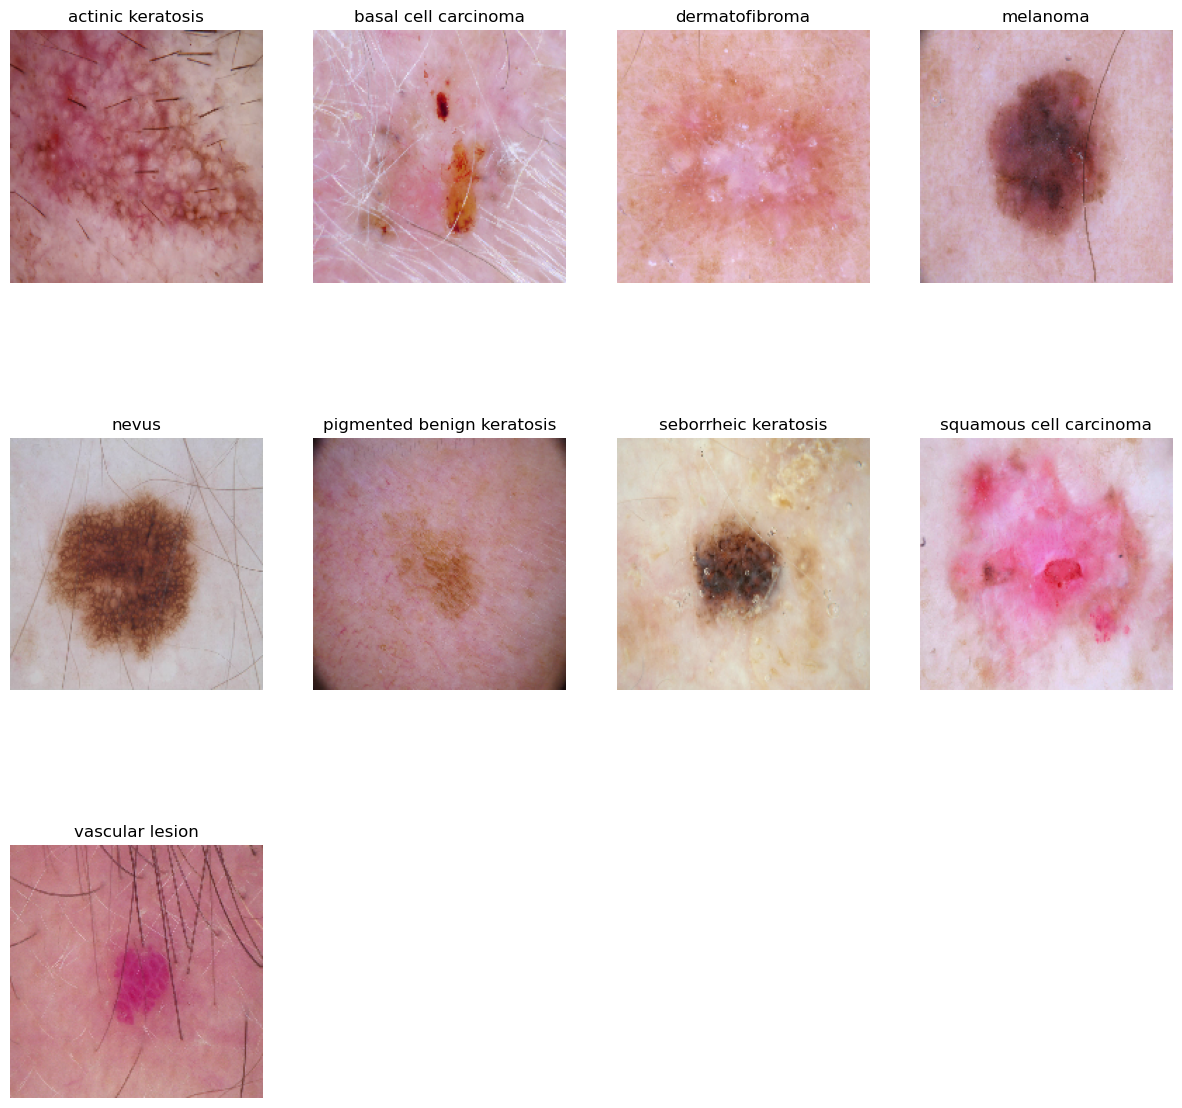

In [11]:


### your code goes here, you can use training or validation data to visualize
##Reading the data
img_data = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, batch_size=batch_size, image_size=(img_height, img_width), seed=123, label_mode='categorical')
## Get prediction classes
class_names=img_data.class_names
## Get the files directory of the images
files_path = {}
for c in class_names:
  files_path[c]=list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x, os.listdir(str(data_dir_train)+'/'+c)))
print(len(files_path))



#Visualizing sample images from each class
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    print(files_path[c][:5])
    path_list = files_path[c][:5]
    index += 1
    plt.subplot(3,4,index)
    plt.imshow(load_img(path_list[0],target_size=(180,180)))
    plt.title(c)
    plt.axis("off")




The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
### Your code goes here
preprocessing_layers = [ tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))]
input_shape = (180,180,3)
learning_rate = 1e-5
activation_fn = 'relu'
padding='Same'

model = Sequential()
model.add(layers.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(Conv2D(32, kernel_size=(3, 3),padding = padding,activation= activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = padding,activation= activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11,11),padding = padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation=activation_fn))
model.add(Dense(9,activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training

In [14]:
### Todo, choose an appropirate optimiser and loss function

learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,verbose=1,factor=0.2, min_lr=learning_rate)
checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1) ##To save the model as a snapshot, which can be reused at later point in time to kick off
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1) ## Generally used to stop the training when it is no longer improving.
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [19]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 module_wrapper (ModuleWrap  (None, 180, 180, 32)      896       
 per)                                                            
                                                                 
 module_wrapper_1 (ModuleWr  (None, 90, 90, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_2 (ModuleWr  (None, 90, 90, 32)        0         
 apper)                                                          
                                                                 
 module_wrapper_3 (ModuleWr  (None, 90, 90, 64)        18496     
 apper)                                                 

In [50]:
!pip install pydot

In [55]:
%conda install python-graphviz

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\Users\Renuka\anaconda3

  added / updated specs:
    - python-graphviz


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2023.12.12 |       haa95532_0         127 KB
    cairo-1.16.0               |       haedb8bc_5         1.9 MB
    certifi-2024.2.2           |  py310haa95532_0         160 KB
    expat-2.5.0                |       hd77b12b_0         225 KB
    fontconfig-2.14.1          |       hc0defaf_1         198 KB
    fribidi-1.0.10             |       h62dcd97_0          63 KB
    getopt-win32-0.1           |       h2bbff1b_0          19 KB
    graphite2-1.3.14           |       hd77b12b_1          91 KB
    graphviz-2.50.0            |       hdb8b0d4_0         903 KB
    gts-0.7.6                  |       h63ab5a1_3         181 KB
    harfbuzz-4.3.0             |       hb6468



==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 24.1.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.0




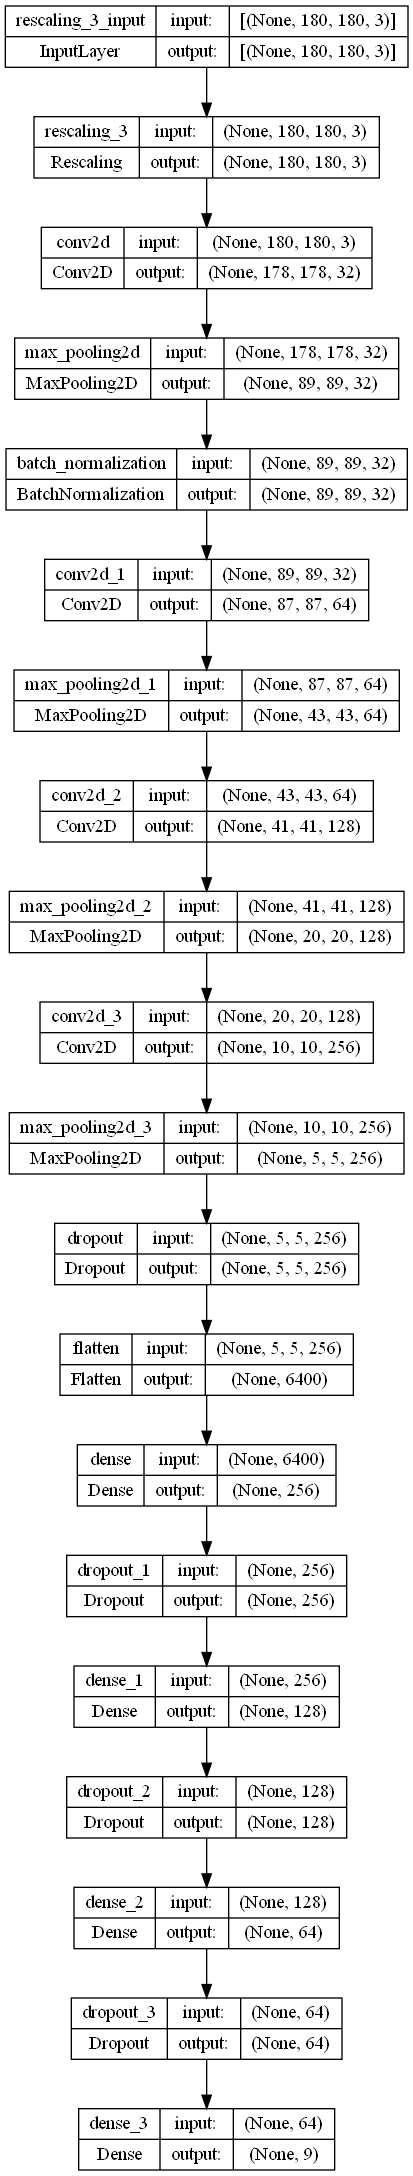

In [56]:
# vizualizing how the model looks like
plot_model(model, to_file='model_plotting.png', show_shapes=True, show_layer_names=True)

### Train the model

In [16]:
epochs = 20

history = model.fit( train_ds,  validation_data=val_ds,  epochs=epochs,  callbacks=[learn_control, checkpoint])

Epoch 1/20


56/56 [==============================] - 82s 1s/step - loss: 2.0702 - accuracy: 0.1931 - val_loss: 2.0912 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 62s 1s/step - loss: 2.0442 - accuracy: 0.1908 - val_loss: 2.0233 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 64s 1s/step - loss: 2.0195 - accuracy: 0.2065 - val_loss: 2.0283 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 63s 1s/step - loss: 2.0220 - accuracy: 0.1914 - val_loss: 2.0222 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 64s 1s/step - loss: 2.0197 - accuracy: 0.2031 - val_loss: 2.0273 - val_accuracy: 0.1924 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - ETA: 0s - loss: 2.0194 - accuracy: 0.2093
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
56/56 [==============================] - 68s 1s/step - loss: 2

### Visualizing training results

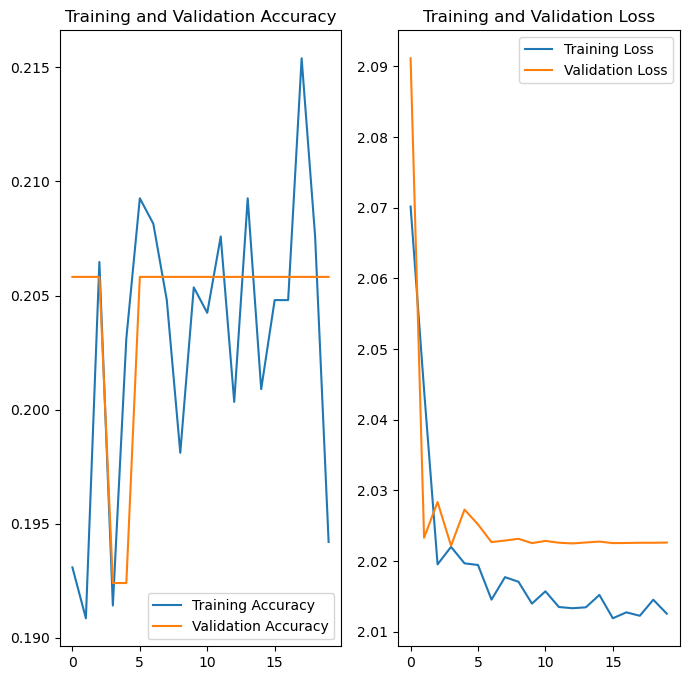

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

In [18]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy, "Validation Accuracy: ",accuracy_v)
print("Loss: ",loss, "Validation Loss", loss_v)


14/14 [==============================] - 3s 222ms/step - loss: 2.0226 - accuracy: 0.2058
Accuracy:  0.2064732164144516 Validation Accuracy:  0.20581655204296112
Loss:  2.012953281402588 Validation Loss 2.0226128101348877


Based on the accuracy graph,

> Both the training and validation accuracy are almost similar, but the value is very low, which indicates that the model is not good. Validation accuracy will mostly be slightly lesser than the training accuracy which is good and depicts the same in our case as well.

Based on the loss graph,

> Training loss seems to be low which is good but on the other hand validation loss is bit high and fluctuating, this indicates again that the model is not good, and is slightly trying to overfit.

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
# Your code goes here
##Using data augmentation
data_augment = tf.keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

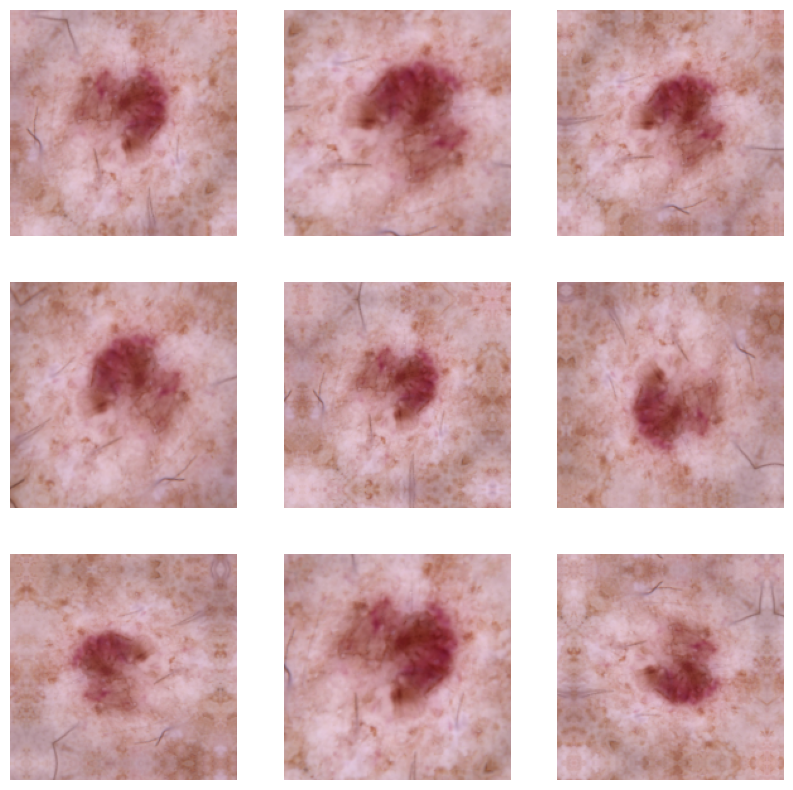

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    image_augmented = data_augment(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_augmented[0].numpy().astype("uint8"))
    plt.axis("off")

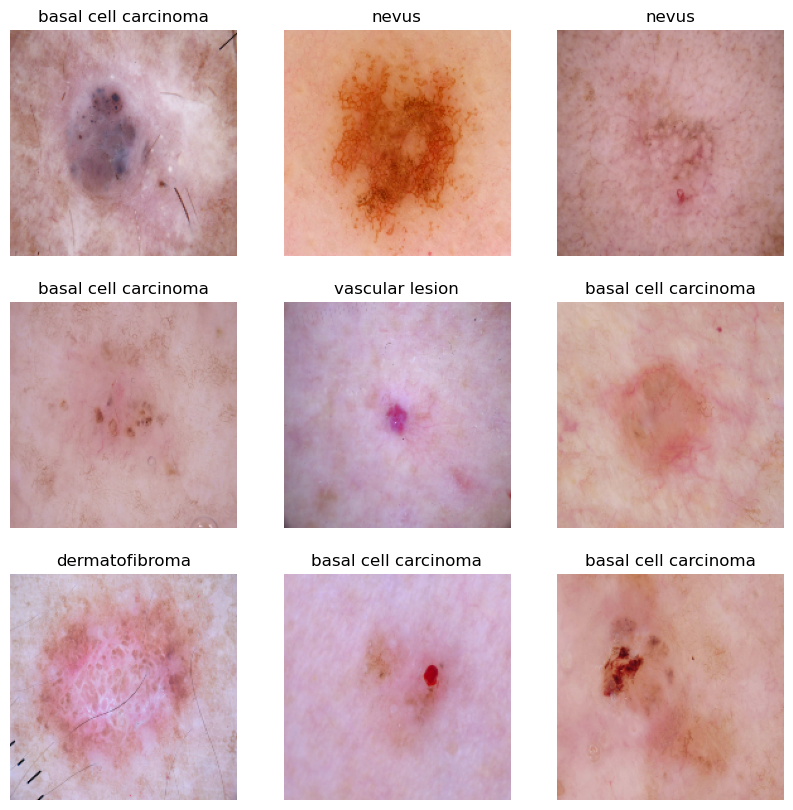

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [22]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
Padding='Same'
## Your code goes here
model = Sequential()

model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3)))
model.add(data_augment)
model.add(Conv2D(32, kernel_size=(3, 3),padding = Padding,activation= activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = Padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = Padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, kernel_size=(3, 3),padding = Padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Conv2D(16, kernel_size=(7, 7),padding = Padding,activation= activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, kernel_size=(11, 11),padding = Padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(256, kernel_size=(3, 3),padding = Padding,activation =activation_fn))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128,activation=activation_fn))
model.add(Dense(9,activation='softmax'))


### Compiling the model

In [23]:
## Your code goes here
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5, verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])


In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 module_wrapper_23 (ModuleW  (None, 180, 180, 32)      896       
 rapper)                                                         
                                                                 
 module_wrapper_24 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                                 
 module_wrapper_25 (ModuleW  (None, 90, 90, 32)        0         
 rapper)                                                         
                                                      

### Training the model

In [25]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = model.fit(  train_ds,  validation_data=val_ds,  epochs=epochs, callbacks=[learn_control])

Epoch 1/20
56/56 [==============================] - 62s 1s/step - loss: 2.0785 - accuracy: 0.1908 - val_loss: 2.0801 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 2/20
56/56 [==============================] - 92s 2s/step - loss: 2.0270 - accuracy: 0.1948 - val_loss: 2.0236 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 3/20
56/56 [==============================] - 81s 1s/step - loss: 2.0187 - accuracy: 0.2003 - val_loss: 2.0203 - val_accuracy: 0.2058 - lr: 0.0010
Epoch 4/20
56/56 [==============================] - 76s 1s/step - loss: 1.9786 - accuracy: 0.2098 - val_loss: 1.9049 - val_accuracy: 0.2841 - lr: 0.0010
Epoch 5/20
56/56 [==============================] - 76s 1s/step - loss: 1.8667 - accuracy: 0.3008 - val_loss: 1.8526 - val_accuracy: 0.2796 - lr: 0.0010
Epoch 6/20
56/56 [==============================] - 76s 1s/step - loss: 1.7634 - accuracy: 0.3209 - val_loss: 2.0022 - val_accuracy: 0.2506 - lr: 0.0010
Epoch 7/20
56/56 [==============================] - 96s 2s/step - loss: 1.7314 - a

### Visualizing the results

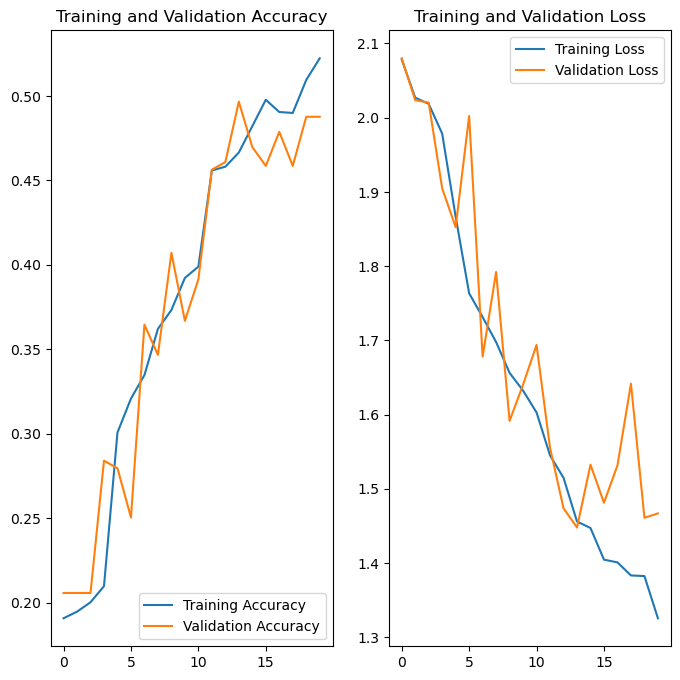

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?


From the accuracy graph,

 The Training accuracy and validation accuracy are almost same. This is a sign of good fit but the accuracy is still very low which is just around 50%. We need to train the model with additional epochs handling class imbalance.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
## Your code goes here.
# images in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)

class_diff

C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  class_diff=class_diff.append({'class':name,'number':number},ignore_index=True)
C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\2091299502.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas i

class  number
0           actinic keratosis     114
1        basal cell carcinoma     376
2              dermatofibroma      95
3                    melanoma     438
4                       nevus     357
5  pigmented benign keratosis     462
6        seborrheic keratosis      77
7     squamous cell carcinoma     181
8             vascular lesion     139

C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\1254120124.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  img_dist_class=img_dist_class.append({'class':name,'number':number},ignore_index=True)
C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\1254120124.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  img_dist_class=img_dist_class.append({'class':name,'number':number},ignore_index=True)
C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\1254120124.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  img_dist_class=img_dist_class.append({'class':name,'number':number},ignore_index=True)
C:\Users\Renuka\AppData\Local\Temp\ipykernel_13532\1254120124.py:6: FutureWarning: The frame.append method is deprecated and will 

'\ndef data_imbalance_check(dir):\n    cnt=[] ## Count for number of images in each class\n    for path in pathlib.Path(dir).iterdir():\n      cnt.append(len([ name for name in os.listdir(path) if os.path.isfile(os.path.join(path,name))]))\n\n    #name of the classes\n    sub_directory = [name for name in os.listdir(dir) if os.path.isdir(os.path.join(dir, name))]\n\n    #return dataframe with class name and number of images in each class\n    return pd.DataFrame(list(zip(sub_directory,cnt)),columns =[\'Class\', \'No. of Images (count)\'])\n\ndf = data_imbalance_check(data_dir_train)\nprint(df)\n\n#Visualize using bar chart\n\nplt.figure(figsize=(10,8))\nsns.barplot( y="Class",x="No. of Images (count)", data=df, label="Class",  legend=False, palette=\'pastel\')\nplt.xticks(rotation=10)\n'

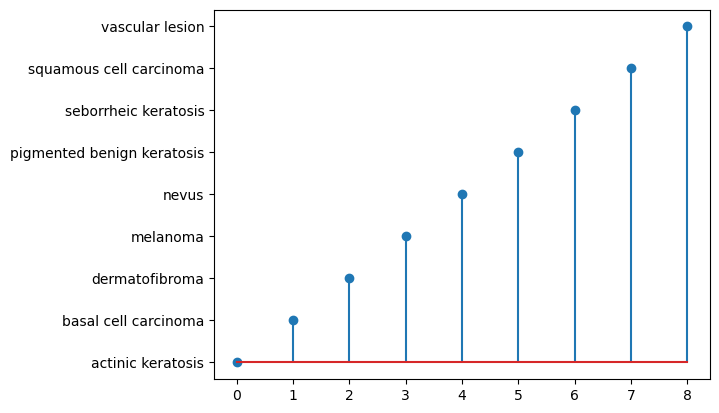

In [28]:
# checking again the total number of images in each classes
img_dist_class=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_dir_train.glob(f'{class_names[i]}/*.jpg')))
  img_dist_class=img_dist_class.append({'class':name,'number':number},ignore_index=True)

plt.stem(img_dist_class['class'])
#plt.xticks('class'),rot=90)
plt.show


#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
seborrheic keratosis - 77 and dermatofibroma - 95
#### - Which classes dominate the data in terms proportionate number of samples?
pigmented benign keratosis (462)

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [29]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [30]:
class_names=['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [31]:
path_to_training_dataset="Skin_cancer/Train/"
#

for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to Skin_cancer/Train/actinic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EF27977F10>: 100%|█| 500/500 [00:12<00:00, 38.62 Samples/


Initialised with 376 image(s) found.
Output directory set to Skin_cancer/Train/basal cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EF28B030D0>: 100%|█| 500/500 [00:20<00:


Initialised with 95 image(s) found.
Output directory set to Skin_cancer/Train/dermatofibroma\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EF27917550>: 100%|█| 500/500 [00:14<00:00, 33.99 Samples/


Initialised with 438 image(s) found.
Output directory set to Skin_cancer/Train/melanoma\output.

Processing <PIL.Image.Image image mode=RGB size=722x542 at 0x1EF27936A70>: 100%|█| 500/500 [01:19<00:00,  6.31 Samples/


Initialised with 357 image(s) found.
Output directory set to Skin_cancer/Train/nevus\output.

Processing <PIL.Image.Image image mode=RGB size=962x723 at 0x1EF27AE7220>: 100%|█| 500/500 [01:18<00:00,  6.37 Samples/


Initialised with 462 image(s) found.
Output directory set to Skin_cancer/Train/pigmented benign keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1EF27914820>: 100%|█| 500/500 [00:16<00:00, 30.25 Samples/


Initialised with 77 image(s) found.
Output directory set to Skin_cancer/Train/seborrheic keratosis\output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x1EE99373DF0>: 100%|█| 500/500 [00:39<00:00, 12.65 Samples


Initialised with 181 image(s) found.
Output directory set to Skin_cancer/Train/squamous cell carcinoma\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EE990864A0>: 100%|█| 500/500 [00:18<00:


Initialised with 139 image(s) found.
Output directory set to Skin_cancer/Train/vascular lesion\output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x1EE97F13FA0>: 100%|█| 500/500 [00:15<00:


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
print(data_dir_train)
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)


Skin_cancer\Train
4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_84239a07-4097-4708-9172-7c53d41e75e1.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_ae53149f-9d25-4d74-a87a-c56db825482e.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025780.jpg_c724361d-5f7f-4298-94cb-bc1515e8291b.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_0407a419-2879-468b-85d5-dbd3f0f5f1b7.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_a4930390-91aa-4f91-b98e-c6165ce49566.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_c45d1adc-2354-4be9-ab07-01c25d0a3bc3.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\\actinic keratosis_original_ISIC_0025803.jpg_c609b54a-9b05-4a08-bdcf-642f90258108.jpg',
 'Skin_cancer\\Train\\actinic keratosis\\output\

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [60]:
for i in class_names:
    directory ='Skin_cancer/Train/'
    directory_out ='Skin_cancer/Train/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


In [37]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = (df2)

In [38]:
new_df['Label'].value_counts()

actinic keratosis             500
basal cell carcinoma          500
dermatofibroma                500
melanoma                      500
nevus                         500
pigmented benign keratosis    500
seborrheic keratosis          500
squamous cell carcinoma       500
vascular lesion               500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [39]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [40]:
data_dir_train="Skin_cancer/Train/"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [41]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [42]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [43]:
### Todo, choose an appropirate optimiser and loss function
learn_control = ReduceLROnPlateau(monitor='val_accuracy', patience=5,
                                  verbose=1,factor=0.2, min_lr=1e-7)
opt=tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [44]:
# View the summary of all layers
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 89, 89, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)       

#### **Todo:**  Train your model

In [45]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
              callbacks=[learn_control, checkpoint]
)

Epoch 1/30
169/169 [==============================] - ETA: 0s - loss: 1.9577 - accuracy: 0.2530
Epoch 1: val_accuracy improved from -inf to 0.15293, saving model to model.h5


C:\Users\Renuka\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


169/169 [==============================] - 458s 3s/step - loss: 1.9577 - accuracy: 0.2530 - val_loss: 2.2833 - val_accuracy: 0.1529 - lr: 0.0010
Epoch 2/30
169/169 [==============================] - ETA: 0s - loss: 1.6704 - accuracy: 0.3698
Epoch 2: val_accuracy improved from 0.15293 to 0.19970, saving model to model.h5
169/169 [==============================] - 505s 3s/step - loss: 1.6704 - accuracy: 0.3698 - val_loss: 2.1676 - val_accuracy: 0.1997 - lr: 0.0010
Epoch 3/30
169/169 [==============================] - ETA: 0s - loss: 1.5430 - accuracy: 0.4052
Epoch 3: val_accuracy improved from 0.19970 to 0.32220, saving model to model.h5
169/169 [==============================] - 421s 2s/step - loss: 1.5430 - accuracy: 0.4052 - val_loss: 1.7582 - val_accuracy: 0.3222 - lr: 0.0010
Epoch 4/30
169/169 [==============================] - ETA: 0s - loss: 1.4673 - accuracy: 0.4353
Epoch 4: val_accuracy improved from 0.32220 to 0.45137, saving model to model.h5
169/169 [=========================

In [46]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy, " Validation Accuracy: ",accuracy_v)
print("Loss: ",loss, " Validation Loss", loss_v)

43/43 [==============================] - 28s 640ms/step - loss: 0.4825 - accuracy: 0.8597
Accuracy:  0.9419510364532471  Validation Accuracy:  0.8596882224082947
Loss:  0.1376471072435379  Validation Loss 0.4825003147125244


#### **Todo:**  Visualize the model results

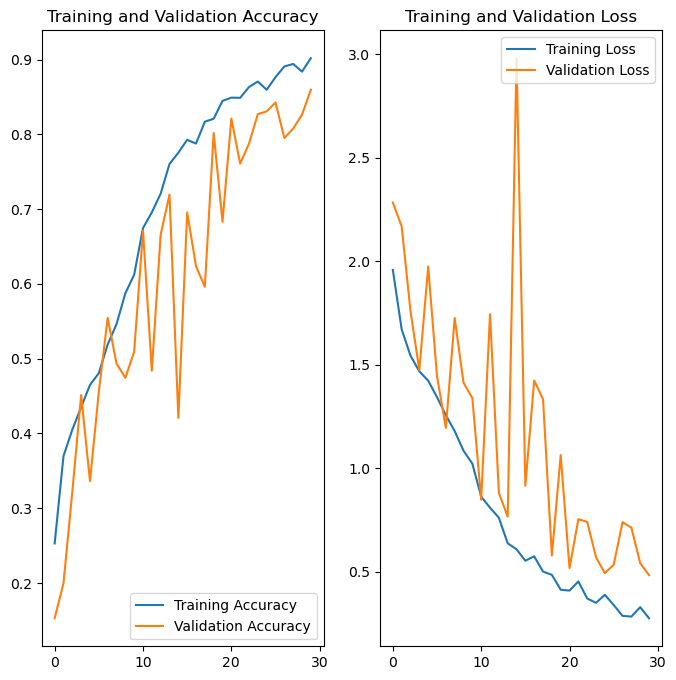

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



The training accuracy that we have obtained is 94.19% And the validation accuracy is 85.96% This is a sign of good fit. And we have pretty good accuracy. The model is able to classify the images with good accuracy when compared with the initial models before handling class imbalance and augmentation.

The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

Initially we tried without the data aumentation which resulted in the model falling for overfitting at a higher ratio. After applying dropout and handling class imbalance along with batch normalization, produced a good model.

1/1 [==============================] - 1s 598ms/step
Actual Class: basal cell carcinoma
Predictive Class: basal cell carcinoma


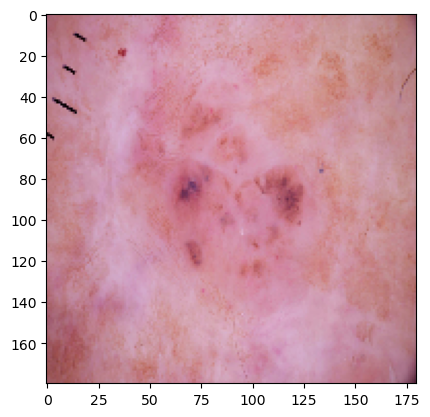

In [48]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array
Test_image_path = os.path.join(data_dir_test, class_names[1], '*')
Test_image = glob(Test_image_path)
Test_image = load_img(Test_image[-1],target_size=(180,180,3))
plt.imshow(Test_image)
plt.grid(False)
 
img = np.expand_dims(Test_image,axis=0)
pred = model.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print(f"Actual Class: {class_names[1]}" + '\n' + "Predictive Class: " + pred_class)